In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from google.colab import drive
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

drive.mount('/content/drive')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
data = pd.read_parquet('drive/MyDrive/news.parquet')

In [3]:
data

,title,category,description,source
0,Amazon Blames Inflation as It Increases Cost o...,Business,The increases are steeper than the 17 percent ...,https://huggingface.co/datasets/okite97/news-data
1,CBN Eyes $200bn from Fresh Non-Oil Exports,Business,The Governor of the Central Bank of Nigeria (C...,https://huggingface.co/datasets/okite97/news-data
2,Buhari Returns Ownership of Four Oil Blocks to...,Business,Nigeria's President Muhammadu Buhari has appro...,https://huggingface.co/datasets/okite97/news-data
3,Indigenous Participation in Nigeria’s Gas Sect...,Business,Chief Executive of the Nigerian Upstream Petro...,https://huggingface.co/datasets/okite97/news-data
4,Multichoice Pays N8bn Deposit In ‘Tax Evasion’...,Business,In complying with the directives of the tax ap...,https://huggingface.co/datasets/okite97/news-data
...,...,...,...,...
180788,Google+ Now Open for Teens With Some Safeguards,Tech,"For the most part, teens' experience on Google...",https://www.kaggle.com/datasets/rmisra/news-ca...
180789,Web Wars,Tech,"These ""Web Wars"" threaten to rage on for some ...",https://www.kaggle.com/datasets/rmisra/news-ca...
180790,"First White House Chief Technology Officer, An...",Tech,He was appointed with a fair bit of fanfare as...,https://www.kaggle.com/datasets/rmisra/news-ca...
180791,Watch The Top 9 YouTube Videos Of The Week,Tech,If you're looking to see the most popular YouT...,https://www.kaggle.com/datasets/rmisra/news-ca...


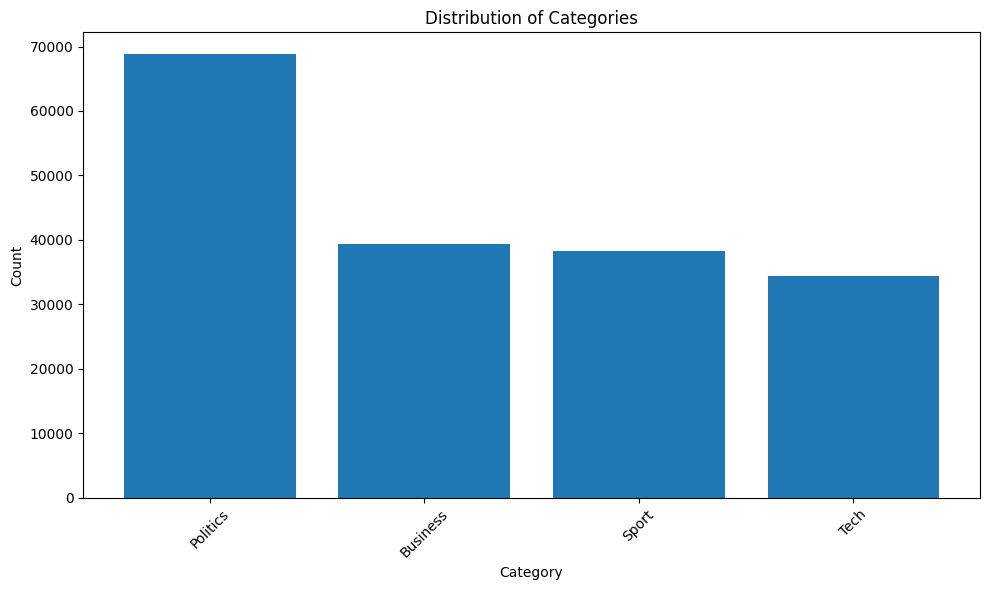

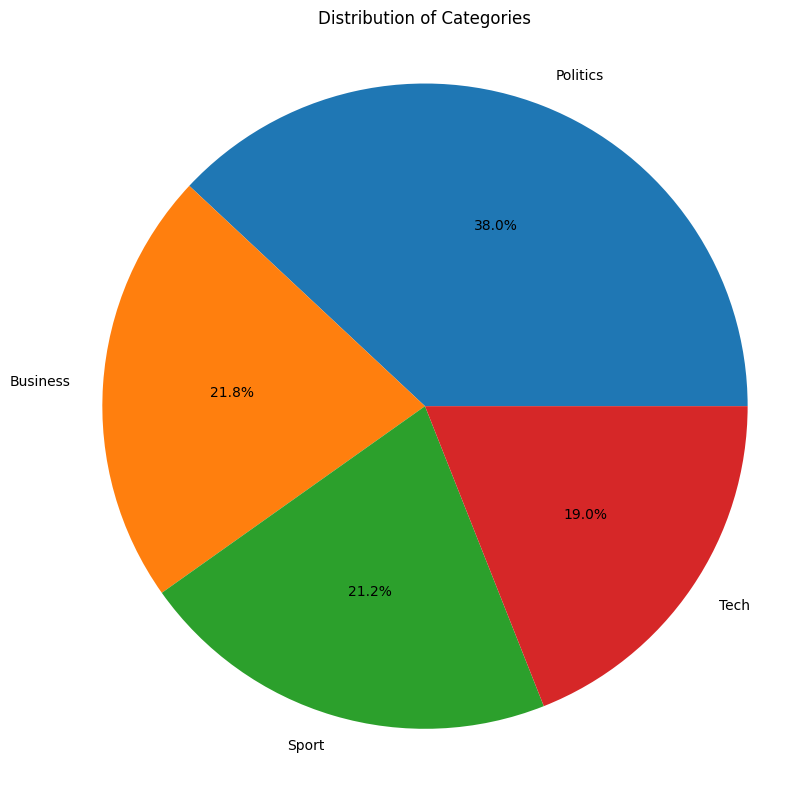

In [4]:
# Count the occurrences of each category
category_counts = data['category'].value_counts()

# Bar Plot
plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Categories')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [5]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

In [6]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub('<[^>]*>', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [ ]:
data['title'] = data['title'].apply(preprocess_text)
data['description'] = data['description'].apply(preprocess_text)

In [ ]:
data['text'] = data['title'] + ' ' + data['description']

In [7]:
# Check if preprocessed data exists
try:
    # Load preprocessed data from file
    with open('drive/MyDrive/3gram_preprocessed_data.pkl', 'rb') as file:
        X, y = pickle.load(file)
    print("Preprocessed data loaded from file.")
except FileNotFoundError:
    # Create trigram features
    vectorizer = CountVectorizer(ngram_range=(1, 3))
    X = vectorizer.fit_transform(data['text'])
    y = data['category']

    # Save preprocessed data to file
    with open('drive/MyDrive/3gram_preprocessed_data.pkl', 'wb') as file:
        pickle.dump((X, y), file)
    print("Preprocessed data saved to file.")

Preprocessed data loaded from file.


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

In [11]:
# Make predictions on the testing set
y_pred = classifier.predict(X_test)

# Calculate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.9054730495865483
Classification Report:
              precision    recall  f1-score   support

    Business       0.87      0.82      0.85      7767
    Politics       0.91      0.94      0.93     13737
       Sport       0.96      0.97      0.96      7703
        Tech       0.87      0.86      0.87      6952

    accuracy                           0.91     36159
   macro avg       0.90      0.90      0.90     36159
weighted avg       0.90      0.91      0.90     36159



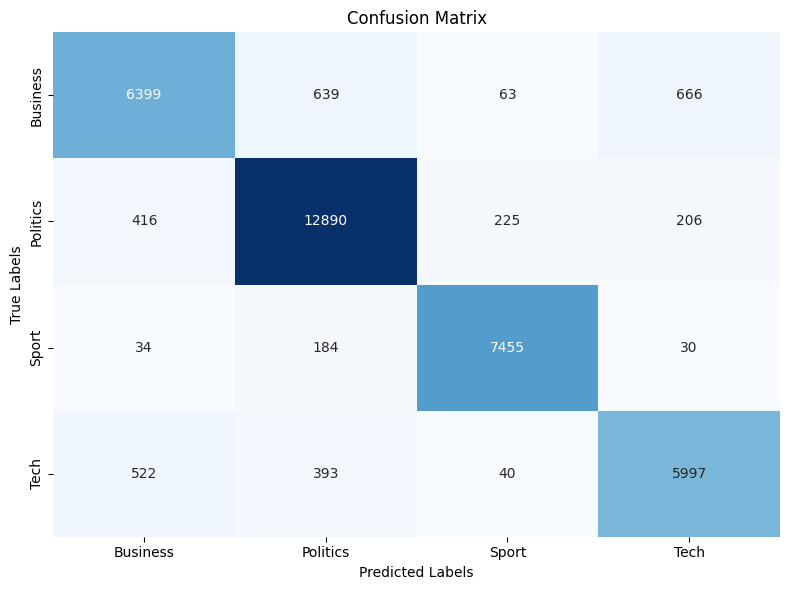

In [12]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
# Create a common vocabulary for all n-gram features
vocabulary = set()

# Build the vocabulary
vectorizer = CountVectorizer(ngram_range=(1, 3))
vectorizer.fit(data['text'])
vocabulary = vectorizer.vocabulary_

In [ ]:
# Create unigram, bigram, and trigram features separately using the common vocabulary
unigram_vectorizer = CountVectorizer(ngram_range=(1, 1), vocabulary=vocabulary)
bigram_vectorizer  = CountVectorizer(ngram_range=(2, 2), vocabulary=vocabulary)
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), vocabulary=vocabulary)

X_unigram = unigram_vectorizer.transform(data['text'])
X_bigram = bigram_vectorizer.transform(data['text'])
X_trigram = trigram_vectorizer.transform(data['text'])
y = data['category']

In [ ]:
# Split the dataset into training and testing sets
X_unigram_train, X_unigram_test, X_bigram_train, X_bigram_test, X_trigram_train, X_trigram_test, y_train, y_test = train_test_split(
    X_unigram, X_bigram, X_trigram, y, test_size=0.2, random_state=42)

In [ ]:
# Train a Multinomial Naive Bayes classifier with feature interpolation
alpha_unigram = 0.25
alpha_bigram = 0.5
alpha_trigram = 1.0

In [ ]:
classifier = MultinomialNB(alpha=alpha_unigram)
classifier.fit(X_unigram_train, y_train)
unigram_probs = classifier.feature_log_prob_

classifier = MultinomialNB(alpha=alpha_bigram)
classifier.fit(X_bigram_train, y_train)
bigram_probs = classifier.feature_log_prob_

classifier = MultinomialNB(alpha=alpha_trigram)
classifier.fit(X_trigram_train, y_train)
trigram_probs = classifier.feature_log_prob_

In [ ]:
interpolated_probs = (alpha_unigram * unigram_probs +
                      alpha_bigram * bigram_probs +
                      alpha_trigram * trigram_probs) / (alpha_unigram + alpha_bigram + alpha_trigram)

classifier.feature_log_prob_ = interpolated_probs

In [ ]:
import numpy as np

# Make predictions on the testing set
y_pred_unigram = classifier.predict(X_unigram_test)
y_pred_bigram = classifier.predict(X_bigram_test)
y_pred_trigram = classifier.predict(X_trigram_test)

# Combine the predictions using majority voting
y_pred = np.array([])
for i in range(len(y_pred_unigram)):
    votes = [y_pred_unigram[i], y_pred_bigram[i], y_pred_trigram[i]]
    y_pred = np.append(y_pred, max(set(votes), key=votes.count))

# Calculate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8772366492436184
Classification Report:
              precision    recall  f1-score   support

    Business       0.84      0.81      0.82      7767
    Politics       0.95      0.86      0.90     13737
       Sport       0.88      0.97      0.92      7703
        Tech       0.80      0.88      0.84      6952

    accuracy                           0.88     36159
   macro avg       0.87      0.88      0.87     36159
weighted avg       0.88      0.88      0.88     36159



In [ ]:
  # Create TF-IDF features
  vectorizer = TfidfVectorizer(ngram_range=(1, 3))
  X = vectorizer.fit_transform(data['text'])
  y = data['category']

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM classifier
classifier = LinearSVC()
classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = classifier.predict(X_test)

# Calculate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.9142951962167095
Classification Report:
              precision    recall  f1-score   support

    Business       0.88      0.85      0.87      7767
    Politics       0.92      0.95      0.93     13737
       Sport       0.96      0.97      0.96      7703
        Tech       0.89      0.87      0.88      6952

    accuracy                           0.91     36159
   macro avg       0.91      0.91      0.91     36159
weighted avg       0.91      0.91      0.91     36159



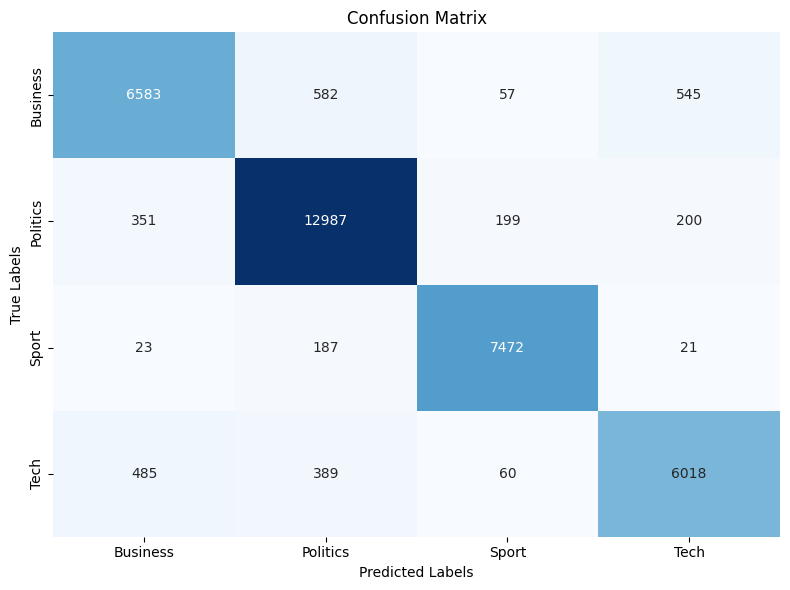

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()